Let's have a look at a movie database and make some recommendations based on user reviews. This is a simplified version of a collaborative filtering recommender system.

In [1]:
import pandas as pd 
import numpy as np
import warnings
warnings.filterwarnings('ignore')

First we load in the ratings file.

In [2]:
df = pd.read_csv('ratings.csv', header=0, names=['user_id','item_id','rating','timestamp'])

In [3]:
df.head()

,user_id,item_id,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


Next we load in the movie titles file.

In [4]:
movie_titles = pd.read_csv('movies.csv')
movie_titles.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


Let's change 'movieId' to 'item_id'.

In [5]:
movie_titles.rename(columns={'movieId':'item_id'}, inplace=True)

In [6]:
movie_titles.head()

,item_id,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [7]:
df = pd.merge(df, movie_titles, on='item_id')
df.head()

,user_id,item_id,rating,timestamp,title,genres
0,1,1,4.0,964982703,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,5,1,4.0,847434962,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
2,7,1,4.5,1106635946,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
3,15,1,2.5,1510577970,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
4,17,1,4.5,1305696483,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy


In [8]:
df.describe()

,user_id,item_id,rating,timestamp
count,100836.000000,100836.000000,100836.000000,1.008360e+05
mean,326.127564,19435.295718,3.501557,1.205946e+09
std,182.618491,35530.987199,1.042529,2.162610e+08
min,1.000000,1.000000,0.500000,8.281246e+08
25%,177.000000,1199.000000,3.000000,1.019124e+09
50%,325.000000,2991.000000,3.500000,1.186087e+09
75%,477.000000,8122.000000,4.000000,1.435994e+09
max,610.000000,193609.000000,5.000000,1.537799e+09


In [9]:
ratings = pd.DataFrame(df.groupby('title')['rating'].mean())

In [12]:
ratings.groupby('rating').head()

,rating
title,
'71 (2014),4.000000
'Hellboy': The Seeds of Creation (2004),4.000000
'Round Midnight (1986),3.500000
'Salem's Lot (2004),5.000000
'Til There Was You (1997),4.000000
...,...
Zoolander (2001),3.509259
Zootopia (2016),3.890625
[REC] (2007),4.062500


In [15]:
ratings['number_of_ratings'] = df.groupby('title')['rating'].count()

In [16]:
ratings.head()

,rating,number_of_ratings
title,,
'71 (2014),4.0,1
'Hellboy': The Seeds of Creation (2004),4.0,1
'Round Midnight (1986),3.5,2
'Salem's Lot (2004),5.0,1
'Til There Was You (1997),4.0,2


Let's do some plotting of the ratings.

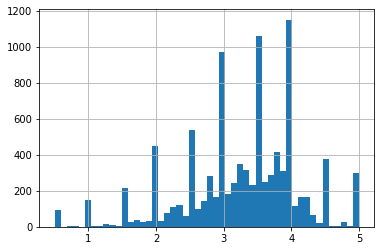

In [18]:
import matplotlib.pyplot as plt
%matplotlib inline
ratings['rating'].hist(bins=50)

Notice the large peaks on whole and half numbers - people tend to give movies "round" number ratings.

Let's look to see how the ratings are distributed, stretching it out a bit with figsize.

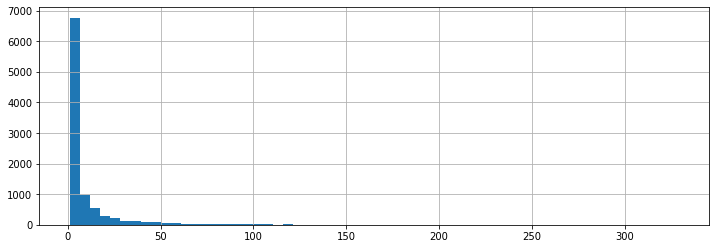

In [21]:
plt.figure(figsize=[12,4])
ratings['number_of_ratings'].hist(bins=60)

Obviously a very small number of movies get the majority of the ratings.

Let's import Seaborn and look at the rating of a movie vs the number of ratings.

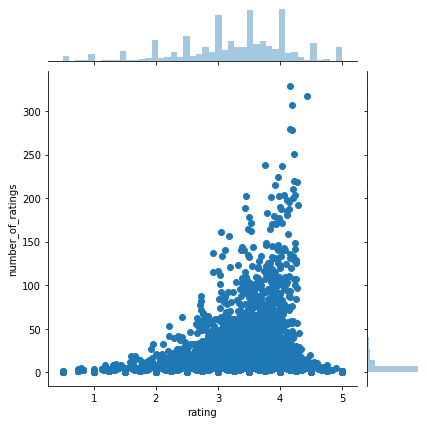

In [23]:
import seaborn as sns
sns.jointplot(x='rating', y='number_of_ratings', data=ratings)

We can see a positive relationship here: either movies are popular because they're good, OR that people just don't want to share negative ratings. I like to think it's the former.

Either way, now that we've explored the data, let's make an actual recommender.

First we'll use a pivot table with user_id as the rows and the movie title as the columns, with ratings as values. This will, of course, produce a very, very large matrix, with mostly null values - since not every user rated every movie - but that's fine for now. We will use this to estimate the rating of a movie for a given user from the ratings of other movies.

In [27]:
movie_matrix = df.pivot_table(index='user_id', columns='title', values='rating')
movie_matrix.head()

title,'71 (2014),'Hellboy': The Seeds of Creation (2004),'Round Midnight (1986),'Salem's Lot (2004),'Til There Was You (1997),'Tis the Season for Love (2015),"'burbs, The (1989)",'night Mother (1986),(500) Days of Summer (2009),*batteries not included (1987),...,Zulu (2013),[REC] (2007),[REC]² (2009),[REC]³ 3 Génesis (2012),anohana: The Flower We Saw That Day - The Movie (2013),eXistenZ (1999),xXx (2002),xXx: State of the Union (2005),¡Three Amigos! (1986),À nous la liberté (Freedom for Us) (1931)
user_id,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Let's see the ratings of the top 10 most rated movies.

In [28]:
ratings.sort_values('number_of_ratings', ascending=False).head(10)

,rating,number_of_ratings
title,,
Forrest Gump (1994),4.164134,329
"Shawshank Redemption, The (1994)",4.429022,317
Pulp Fiction (1994),4.197068,307
"Silence of the Lambs, The (1991)",4.161290,279
"Matrix, The (1999)",4.192446,278
Star Wars: Episode IV - A New Hope (1977),4.231076,251
Jurassic Park (1993),3.750000,238
Braveheart (1995),4.031646,237
Terminator 2: Judgment Day (1991),3.970982,224


Now let's see the number of ratings of the top 10 BEST rated movies.

In [29]:
ratings.sort_values('rating', ascending=False).head(10)

,rating,number_of_ratings
title,,
Gena the Crocodile (1969),5.0,1
True Stories (1986),5.0,1
Cosmic Scrat-tastrophe (2015),5.0,1
Love and Pigeons (1985),5.0,1
Red Sorghum (Hong gao liang) (1987),5.0,1
"Thin Line Between Love and Hate, A (1996)",5.0,1
Lesson Faust (1994),5.0,2
Eva (2011),5.0,1
Who Killed Chea Vichea? (2010),5.0,1


No, I haven't heard of most of these either. Cult faves, I guess!

Now let's examine and compare some specific movies.

In [30]:
matrix_user_rating = movie_matrix['Matrix, The (1999)']
t2_user_rating = movie_matrix['Terminator 2: Judgment Day (1991)']

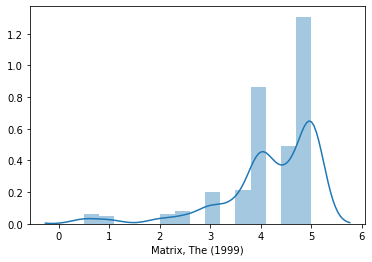

In [31]:
sns.distplot(matrix_user_rating)

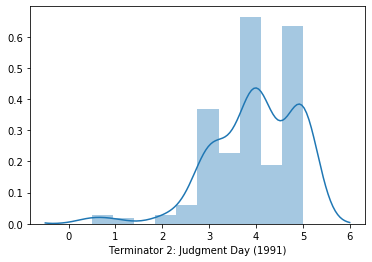

In [32]:
sns.distplot(t2_user_rating)

Sayeth the people: Matrix beats T2.
    
Now let's check their correlation with the overall ratings using corrwith():

In [46]:
similar_to_matrix=movie_matrix.corrwith(matrix_user_rating)

In [48]:
similar_to_matrix.head()

title
'71 (2014)                                NaN
'Hellboy': The Seeds of Creation (2004)   NaN
'Round Midnight (1986)                    NaN
'Salem's Lot (2004)                       NaN
'Til There Was You (1997)                 NaN
dtype: float64

In [47]:
corr_matrix = pd.DataFrame(similar_to_matrix,columns=['Correlation'])
corr_matrix.dropna(inplace=True)
corr_matrix.head()

,Correlation
title,
"'burbs, The (1989)",-0.160843
(500) Days of Summer (2009),0.302316
*batteries not included (1987),0.392232
...And Justice for All (1979),0.654654
10 Cent Pistol (2015),-1.000000


Now let's sort them by correlation.

In [55]:
corr_matrix.sort_values('Correlation',ascending=False).head(10)

,Correlation
title,
Haywire (2011),1.0
Highway 61 (1991),1.0
World on a Wire (Welt am Draht) (1973),1.0
"War Zone, The (1999)",1.0
"Hitcher, The (1986)",1.0
Gross Anatomy (a.k.a. A Cut Above) (1989),1.0
Paper Towns (2015),1.0
Juwanna Mann (2002),1.0
Topsy-Turvy (1999),1.0


A perfect correlation between all those movies and The Matrix? Only in a small data set.

Now let's try it with T2:

In [51]:
similar_to_t2=movie_matrix.corrwith(t2_user_rating)

In [52]:
corr_t2 = pd.DataFrame(similar_to_t2,columns=['Correlation'])
corr_t2.dropna(inplace=True)
corr_t2.head()

,Correlation
title,
"'burbs, The (1989)",-0.050602
(500) Days of Summer (2009),0.411008
*batteries not included (1987),0.566379
...And Justice for All (1979),-0.327327
10 Cent Pistol (2015),-1.000000


In [53]:
corr_t2.sort_values('Correlation',ascending=False).head(10)

,Correlation
title,
"Great Yokai War, The (Yôkai daisensô) (2005)",1.0
Barbershop 2: Back in Business (2004),1.0
Killers (2010),1.0
Summer Rental (1985),1.0
Dead or Alive: Hanzaisha (1999),1.0
"Serbian Film, A (Srpski film) (2010)",1.0
Suburban Commando (1991),1.0
"Stunt Man, The (1980)",1.0
"Wolfman, The (2010)",1.0


Again, all perfect correlations? Seems strange.

Let's try filtering out the movies which have very few reviews.

In [61]:
corr_matrix = corr_matrix.join(ratings['number_of_ratings'])
corr_matrix.head()

,Correlation,number_of_ratings
title,,
"'burbs, The (1989)",-0.160843,17
(500) Days of Summer (2009),0.302316,42
*batteries not included (1987),0.392232,7
...And Justice for All (1979),0.654654,3
10 Cent Pistol (2015),-1.000000,2


Now let's sort them:

In [70]:
corr_matrix[corr_matrix['number_of_ratings']>10].sort_values('Correlation',ascending=False).head()

,Correlation,number_of_ratings
title,,
"Matrix, The (1999)",1.000000,278
Nixon (1995),1.000000,18
Murder in the First (1995),1.000000,13
Circle of Friends (1995),0.983739,16
"American in Paris, An (1951)",0.968330,12


This doesn't seem that useful. Let's try a higher threshold of ratings:

In [72]:
corr_matrix[corr_matrix['number_of_ratings']>100].sort_values('Correlation',ascending=False).head()

,Correlation,number_of_ratings
title,,
"Matrix, The (1999)",1.000000,278
Die Hard (1988),0.544466,145
Inception (2010),0.514767,143
Braveheart (1995),0.496045,237
Aliens (1986),0.470865,126


That's better!

Now we do the same for T2:

In [69]:
corr_t2 = pd.DataFrame(similar_to_t2,columns=['Correlation'])
corr_t2.dropna(inplace=True)
corr_t2 = corr_t2.join(ratings['number_of_ratings'])
corr_t2[corr_t2['number_of_ratings']>100].sort_values('Correlation',ascending=False).head()

,Correlation,number_of_ratings
title,,
Terminator 2: Judgment Day (1991),1.000000,224
"Terminator, The (1984)",0.689997,131
Trainspotting (1996),0.546834,102
Die Hard (1988),0.495921,145
Outbreak (1995),0.493281,101


From this we can see that people who like The Matrix also like Die Hard, Inception, Braveheart and Aliens. Seems reasonable. 

We can also see that people who like T2 also like T1, Trainspotting, Die Hard and Outbreak. Sounds about right!